In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import plot_all_conditions, plot_condition_classes
from sklearn.linear_model import LinearRegression



In [146]:
path = './data'
txt_files = sorted(list_files_with_extension(path, '.txt'))

# Add a 'time_index' column before concatenating all_X
all_X = []

for i, file in enumerate(txt_files):
    file_idx = i
    file_name = file.split('_')[-1]
    condition = file_name.split(' ')[-1].replace('.txt', '')
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    # X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['file_idx'] = file_idx
    X_local['file_name'] = file_name
    X_local['condition'] = condition    
    all_X.append(X_local)
    print(i, ':', file_name, "condition:", condition)

all_X = pd.concat(all_X, ignore_index=True)


0 : Manual Calibration Full Setup Water Burn 50.txt condition: 50
1 : Manual Calibration Full Setup Water Burn 25.txt condition: 25
2 : Manual Calibration Full Setup Water Burn 37.5.txt condition: 37.5


In [147]:
# Define calibration parameters as variables from Rad 8 calibration
RadSlopeChange = 0.000497500472957584 #V/°C²
RadSlope0 = -0.05086460656085395 #V/°C
RadOffsetChange = 0.0012766597544389732 #V/°C
RadOffset0 = 0.039633792707224266 #V
HousingSlope = 96.62161268564931 #°C/V
HousingOffset = -48.75916244561122 #°C

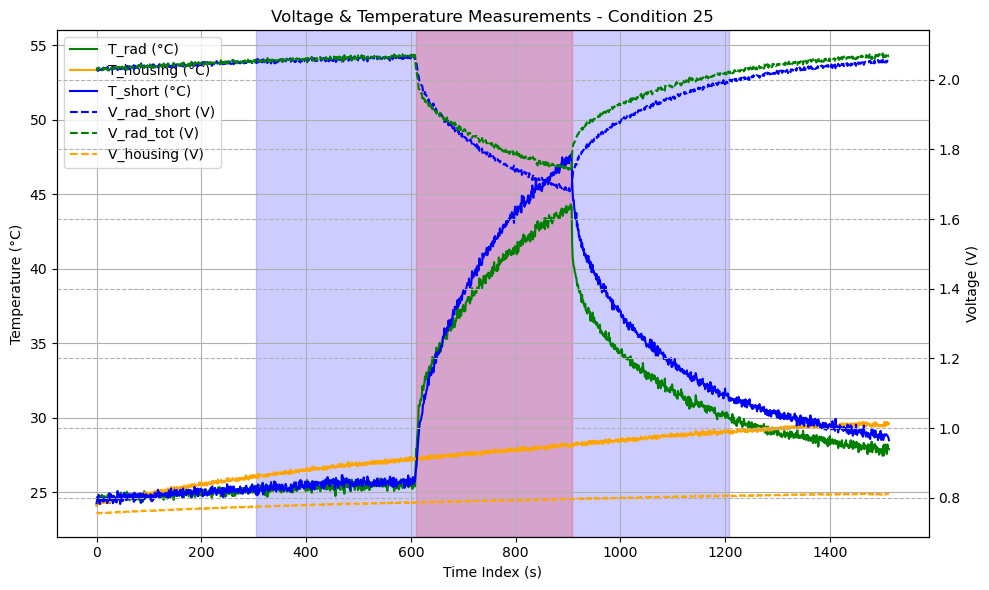

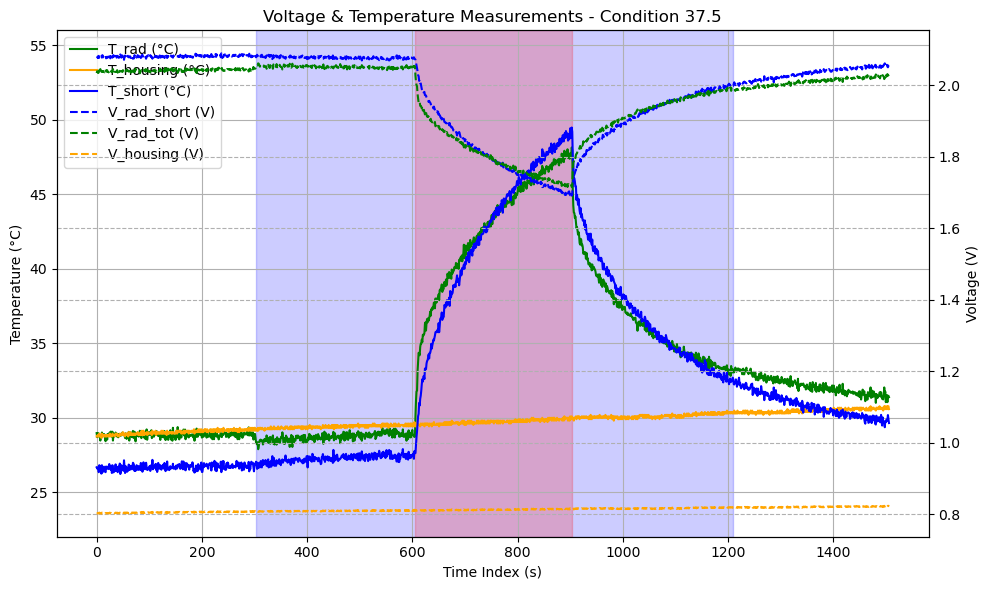

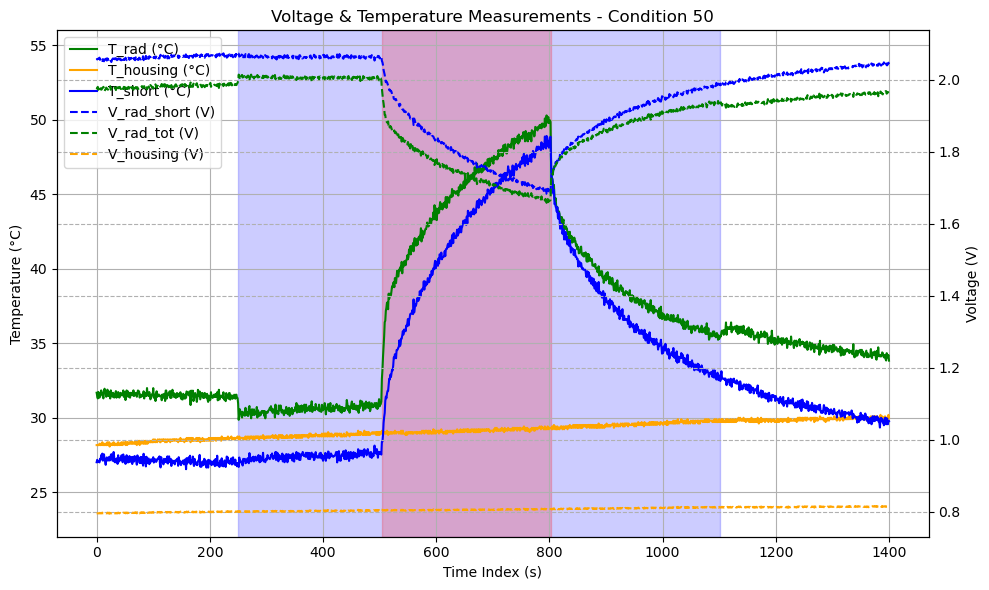

In [148]:
all_X["T_housing"] = T_housing_func(all_X["V_housing"]/1000, HousingSlope, HousingOffset)
all_X["T_rad"] = T_rad_func(all_X["V_rad_tot"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)
all_X["T_short"] = T_rad_func(all_X["V_rad_short"]/1000, all_X["T_housing"], RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

variables_right = ['V_rad_short', 'V_rad_tot', 'V_housing',]
variables_left = ['T_rad', 'T_housing', 'T_short']
y_axes_right_lims = (None, None)
y_axes_left_lims = (22, 56)

variables_colors = {
    'V_rad_short': 'blue',
    'V_rad_tot': 'green',
    'V_housing': 'orange',
    'V_diode': 'red',
    'V_spike': 'purple',
    'T_housing': 'orange',
    'T_rad': 'green',
    'T_short': 'blue',
    'T_antenna': 'purple',
    'T_diode': 'red',
    'T_end_of_cable': 'brown',
    'T_total_calc': 'black',
}
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)',
    'T_housing': 'T_housing (°C)',
    'T_rad': 'T_rad (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_short': 'T_short (°C)',
    'T_diode': 'T_diode (°C)',
    'T_end_of_cable': 'T_end_of_cable (°C)',
    'T_total_calc': 'T_total_calc (°C)',
}

def plot(
        df, variables_right, y_axes_right_lims,
        variables_left,  y_axes_left_lims, variables_colors, labels, plot_title = "Voltage & Temperature Measurements"
        ):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    legend_lines = []
    legend_labels = []
    for var in variables_left:
        ax1.plot(df.time_index, df[var], label=labels[var], color=variables_colors[var])
    ax1.set_xlabel("Time Index (s)")
    ax1.set_ylabel("Temperature (°C)")
    ax1.grid(True)
    ax1.set_ylim(y_axes_left_lims)
    lines1, labels1 = ax1.get_legend_handles_labels()
    legend_lines += lines1
    legend_labels += labels1


    if len(variables_right) > 0:
        ax2 = ax1.twinx()
        for var in variables_right:
            ax2.plot(df.time_index, df[var]/1000, label=labels[var], linestyle='--', color=variables_colors[var])
        ax2.set_ylabel("Voltage (V)")
        ax2.grid(True, linestyle='--')
        ax2.set_ylim(y_axes_right_lims)

        # Combine legends

        lines2, labels2 = ax2.get_legend_handles_labels()
        legend_lines += lines2
        legend_labels += labels2
        

    cooling_periods = df[df['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='blue', alpha=0.2)

    power_periods = df[df['power'] > 0]
    if not power_periods.empty:
        power_periods = power_periods.copy()
        power_periods['group'] = (power_periods['time_index'].diff() != 1).cumsum()
        for _, group in power_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            ax1.axvspan(start, end, color='red', alpha=0.2)
            
    ax1.legend(legend_lines, legend_labels, loc='upper left')

    plt.title(plot_title)
    plt.tight_layout()
    plt.show()

conditions = ["25", "37.5", "50"]

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Voltage & Temperature Measurements - Condition {cond}"
        )


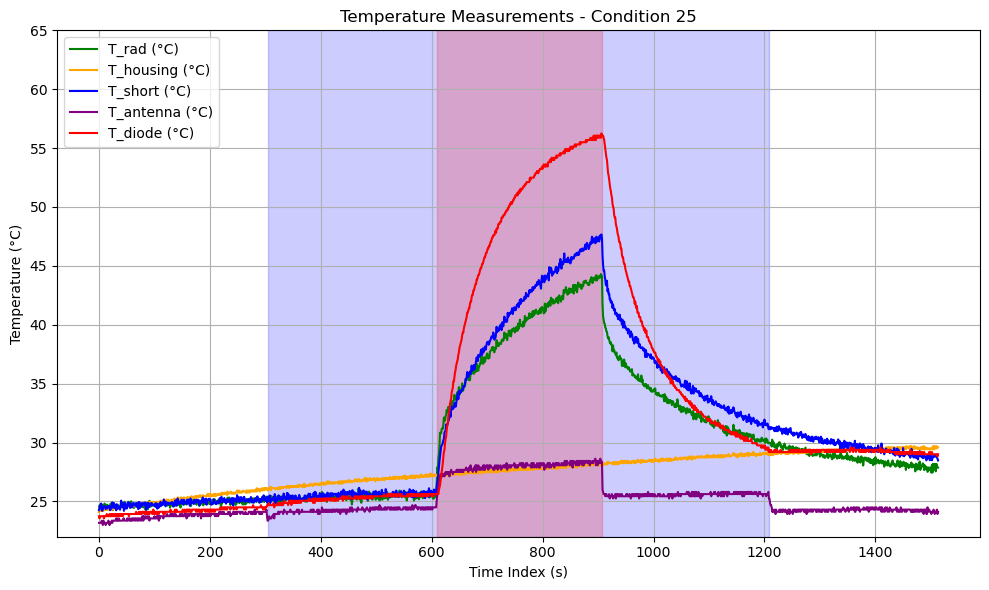

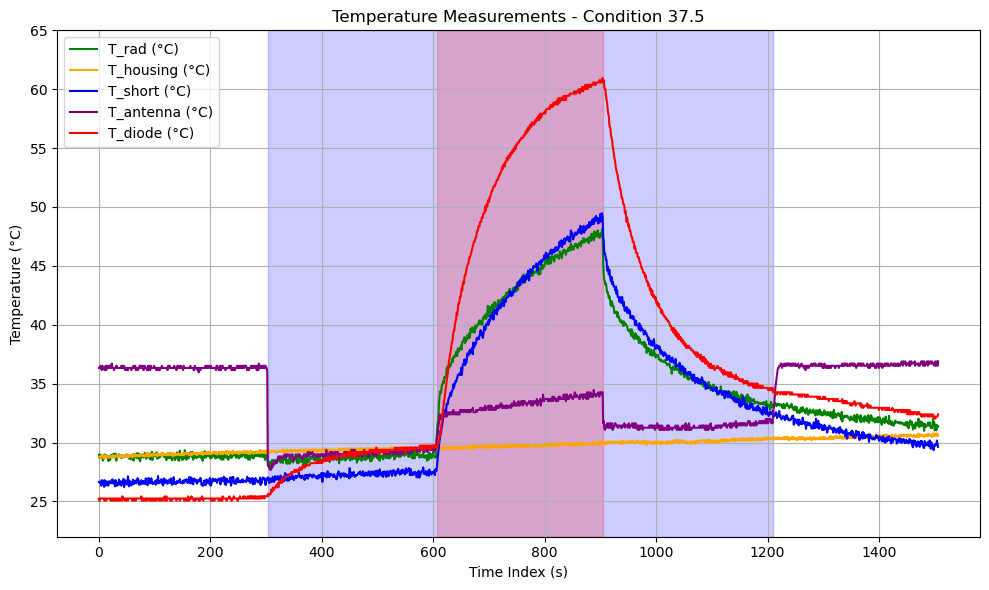

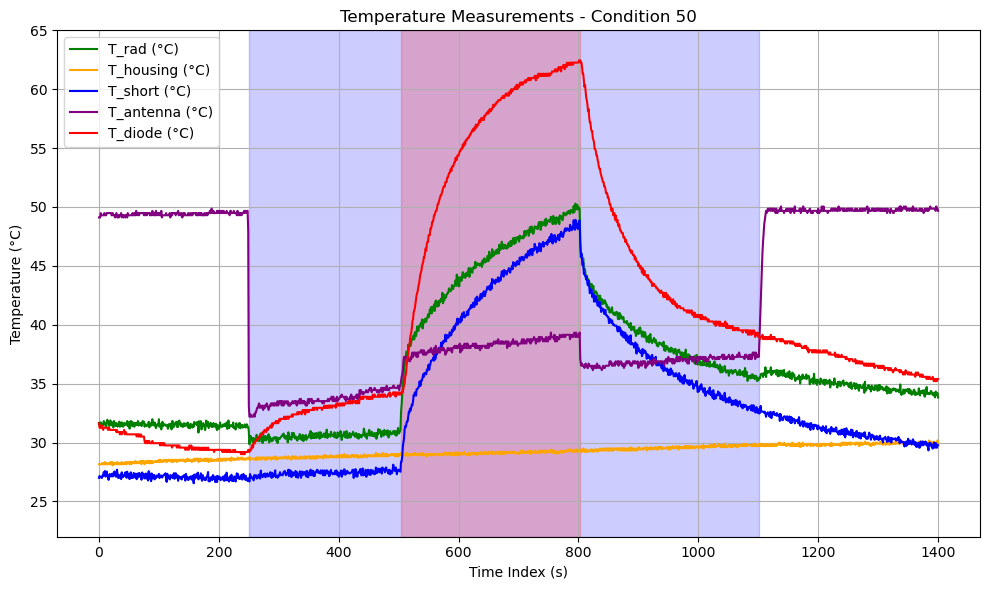

In [149]:
AntennaSlope = 187.904012
AntennaOffset = 0.628991

all_X["T_antenna"] = T_housing_func(all_X["V_spike"]/1000, AntennaSlope, AntennaOffset)
all_X["T_diode"] = T_housing_func(all_X["V_diode"]/1000, AntennaSlope, AntennaOffset)

variables_left = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode']
variables_right = []
y_axes_left_lims = (22, 65)


for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Temperature Measurements - Condition {cond}"
        )



In [150]:
def get_cable_tau_and_Tcable(tau_T, T_total, tau_D, T_diplexer):
    tau_C = tau_T / (tau_D)
    T_cable = (
        T_total * (1-tau_T) 
        - T_diplexer * (1-tau_D)
        ) / (tau_D*(1-tau_C))
    return tau_C, T_cable

# Cable parameters

slope_tau_t = -0.00196
intercept_tau_t = 0.366
tau_D = 0.70
T_diplexer = 27

for i, r in all_X.iterrows():
    tau_tot, T_tot = solve_tau_pre_diode_T_pre_diode(
        r["T_short"],
        r["T_housing"],
        slope_tau_t,
        intercept_tau_t
    )
    if T_tot is None: 
        print(f"Row {i}: T_tot is None")
        all_X.loc[i, "T_end_of_cable"] = None
    else:
        all_X.loc[i, "tau_T_calc"] = tau_tot
        all_X.loc[i, "T_total_calc"] = T_tot
        T_end_of_cable = T_tissue_cable_func(
            r["T_rad"],
            T_tot,
            tau_tot
        )
        tau_cable, T_cable = get_cable_tau_and_Tcable(
            tau_tot,
            T_tot,
            tau_D,
            T_diplexer,
        )
        all_X.loc[i, "tau_C_calc"] = tau_cable
        all_X.loc[i, "T_cable_calc"] = T_cable
        all_X.loc[i, "T_end_of_cable"] = T_end_of_cable


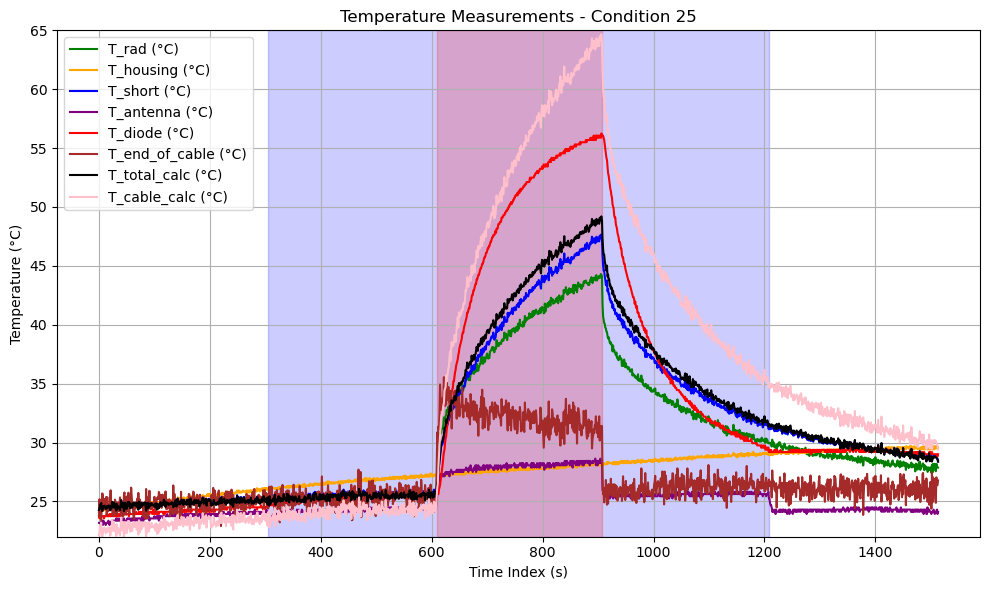

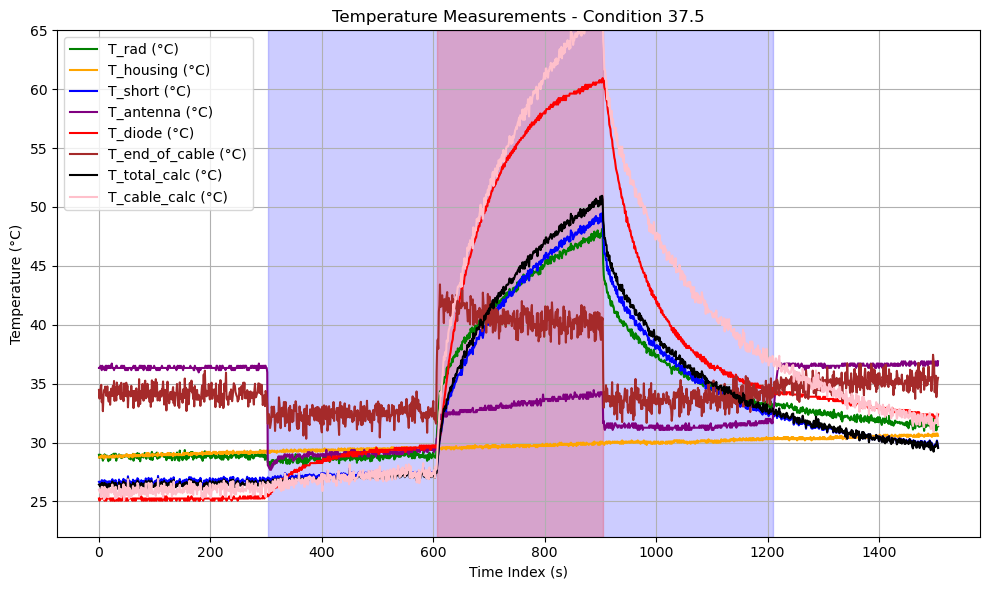

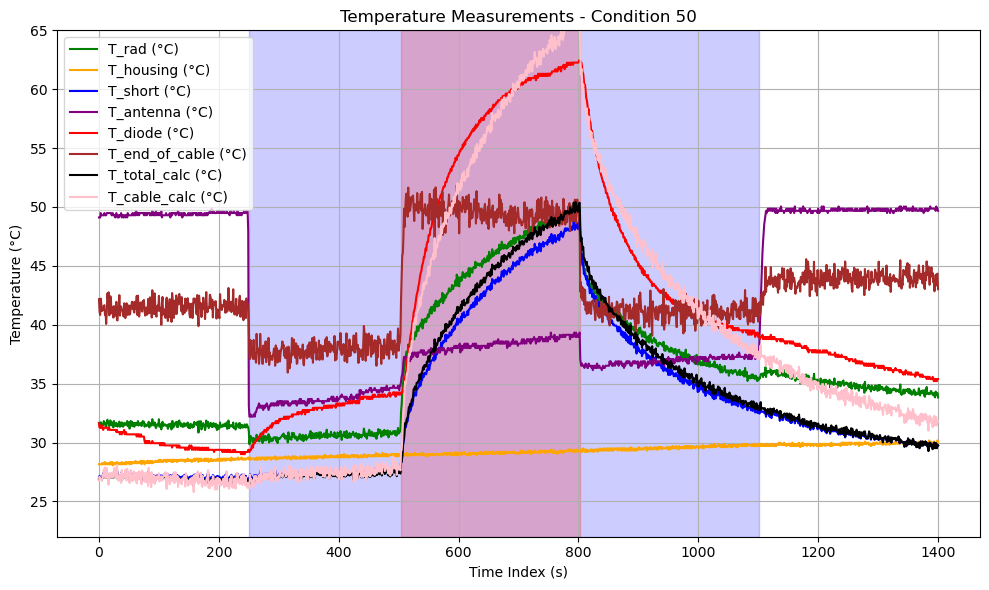

In [151]:
variables_left = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode', 'T_end_of_cable', 'T_total_calc']
variables_left.append('T_cable_calc')
labels['T_cable_calc'] = 'T_cable_calc (°C)'
variables_colors['T_cable_calc'] = 'pink'

y_axes_left_lims = (22, 65)

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Temperature Measurements - Condition {cond}"
        )

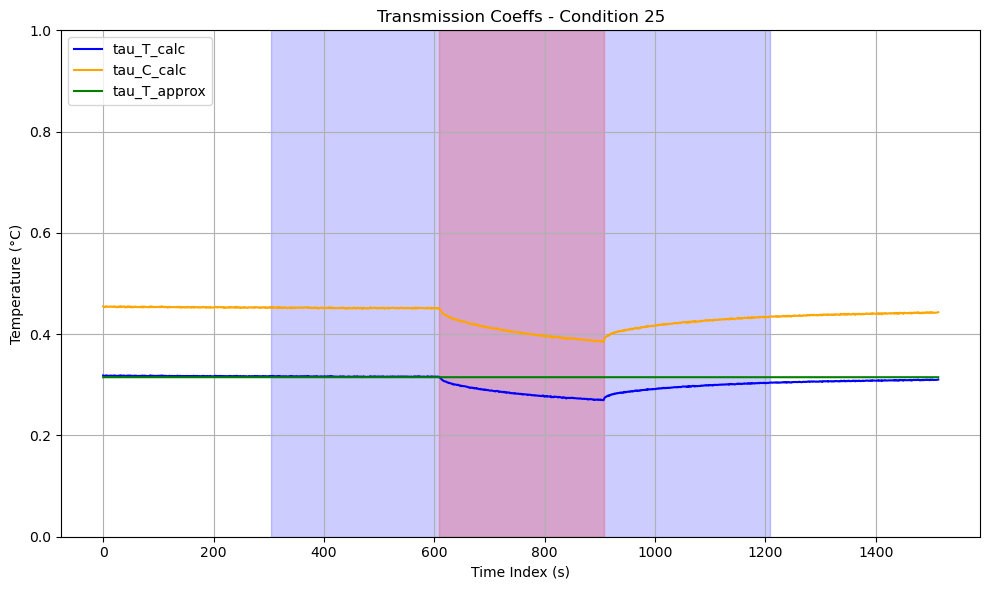

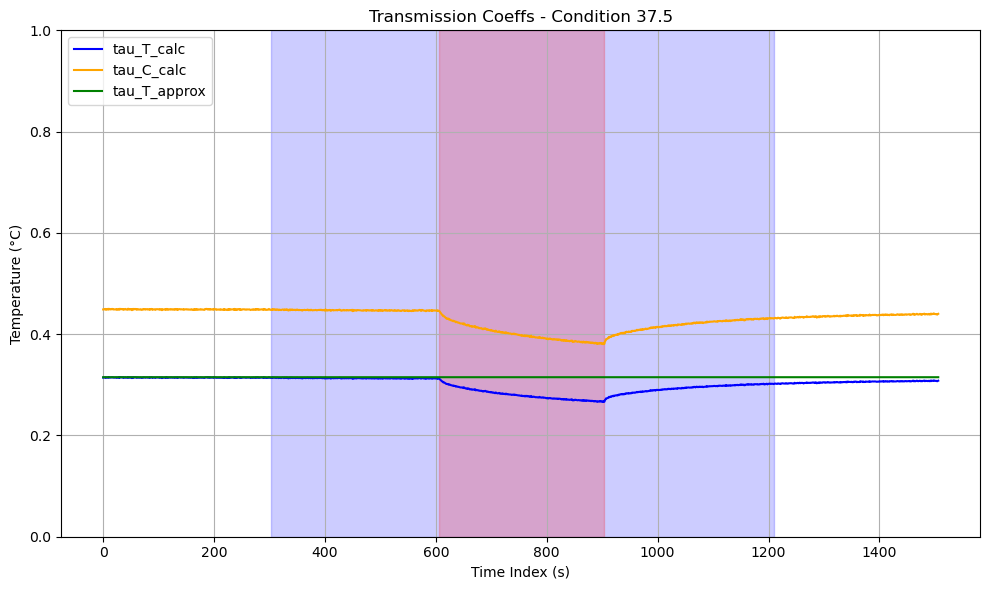

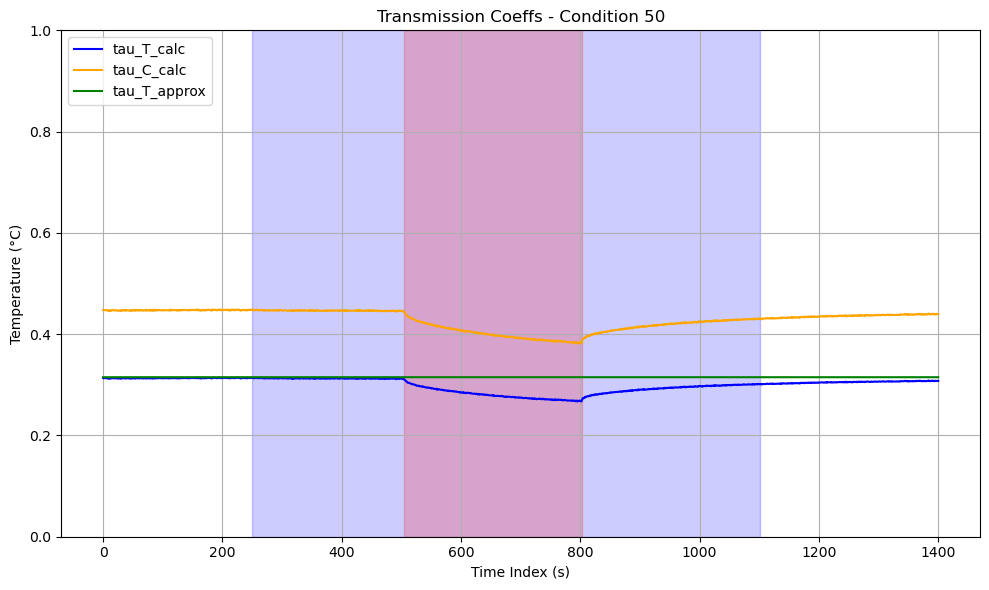

In [152]:
_variables_left = ['tau_T_calc', 'tau_C_calc', 'tau_T_approx']
_labels = {
    'tau_T_calc': 'tau_T_calc',
    'tau_C_calc': 'tau_C_calc',
    'tau_T_approx': 'tau_T_approx',
}
_variables_colors = {
    'tau_T_calc': 'blue',
    'tau_C_calc': 'orange',
    'tau_T_approx': 'green',
}
_y_axes_left_lims = (0, 1)
tau_T_approx = 0.315    
all_X['tau_T_approx'] = tau_T_approx

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        _variables_left, _y_axes_left_lims, _variables_colors, _labels, plot_title = f"Transmission Coeffs - Condition {cond}"
        )

In [153]:
for i, r in all_X.iterrows():

    T_end_of_cable = T_tissue_cable_func(
        r["T_rad"],
        r["T_total_calc"],
        tau_T_approx
    )
    all_X.loc[i, "T_end_of_cable_test"] = T_end_of_cable

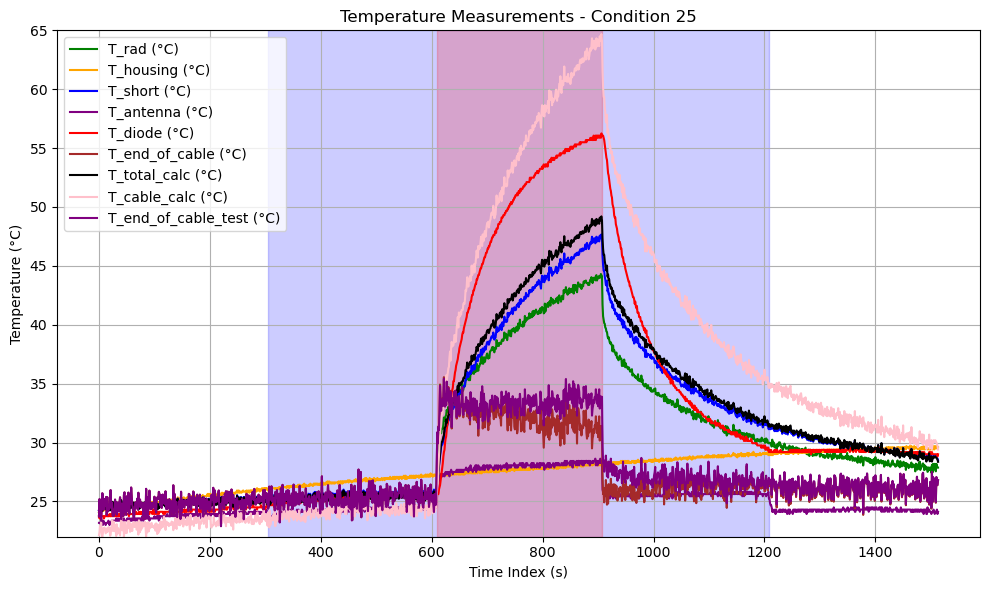

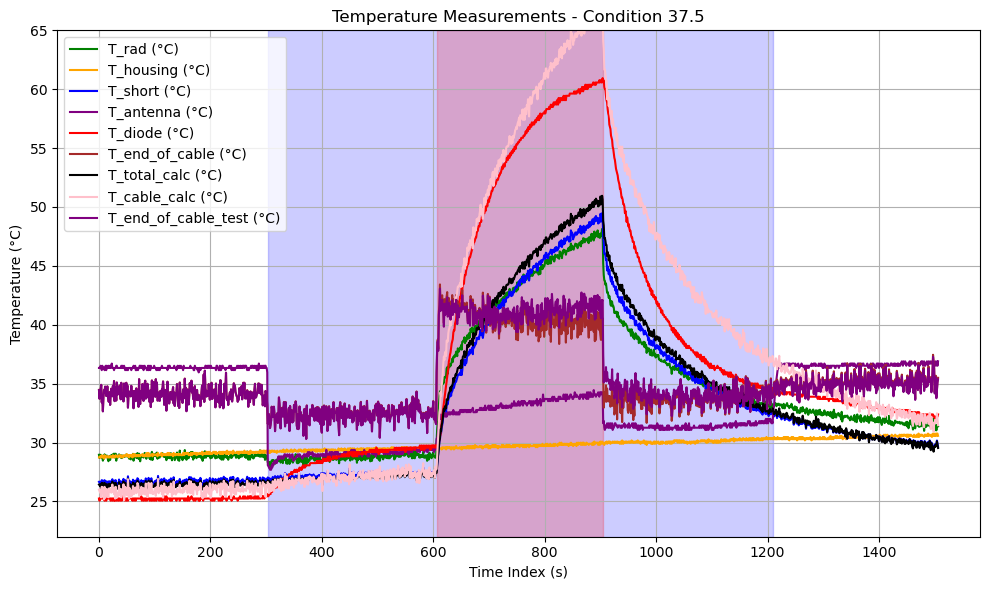

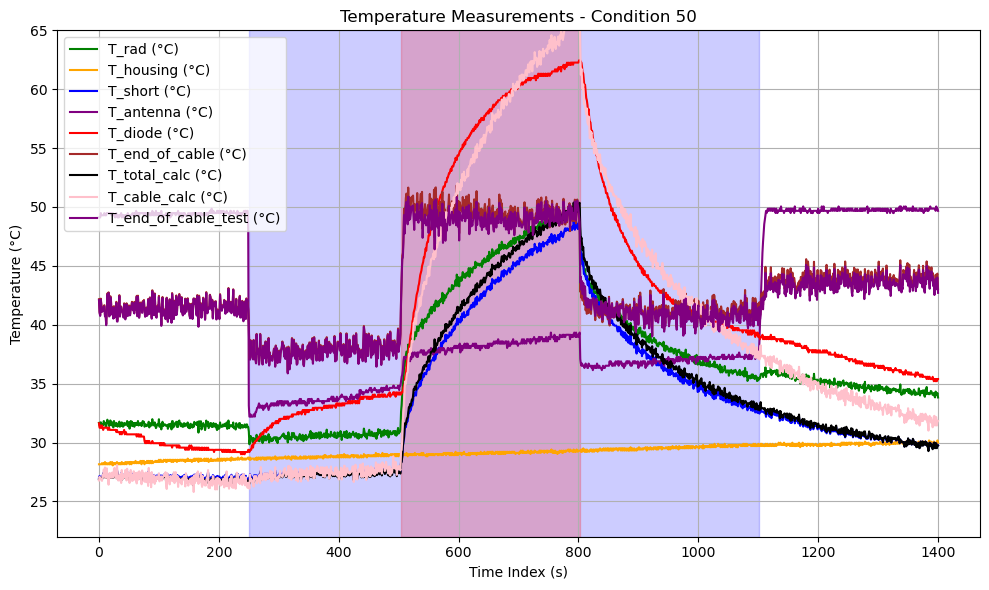

In [154]:
variables_left = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode', 'T_end_of_cable', 'T_total_calc', ]
variables_left.append('T_cable_calc')
labels['T_cable_calc'] = 'T_cable_calc (°C)'
variables_colors['T_cable_calc'] = 'pink'

variables_left.append('T_end_of_cable_test')
labels['T_end_of_cable_test'] = 'T_end_of_cable_test (°C)'
variables_colors['T_end_of_cable_test'] = 'purple'

y_axes_left_lims = (22, 65)

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Temperature Measurements - Condition {cond}"
        )

In [139]:

# Antenna parameters

tau_h = 0.6424308991704384
tau_a = 0.6720461700531027


In [140]:
def T_tissue_with_handle(T_eoc, T_handle, T_antenna, tau_handle, tau_antenna):
    # return (T_eoc - T_bath*tau_antenna*tau_handle - T_antenna*tau_handle*(1 - tau_antenna)) / (1 - tau_handle)
    return (T_eoc - T_antenna*tau_handle*(1 - tau_antenna) - T_handle*(1-tau_handle)) / (tau_antenna*tau_handle)

def calculate_T_handle(T_eoc, T_bath, T_antenna, tau_handle, tau_antenna):
    return (T_eoc - T_bath*(tau_antenna*tau_handle) - T_antenna*tau_handle*(1 - tau_antenna)) / ((1-tau_handle))

In [141]:
all_X["T_bath_cal"] = all_X.apply(lambda row: T_tissue_with_handle(
    row["T_end_of_cable"],
    26,
    row["T_antenna"],
    tau_h,
    tau_a,
), axis=1)

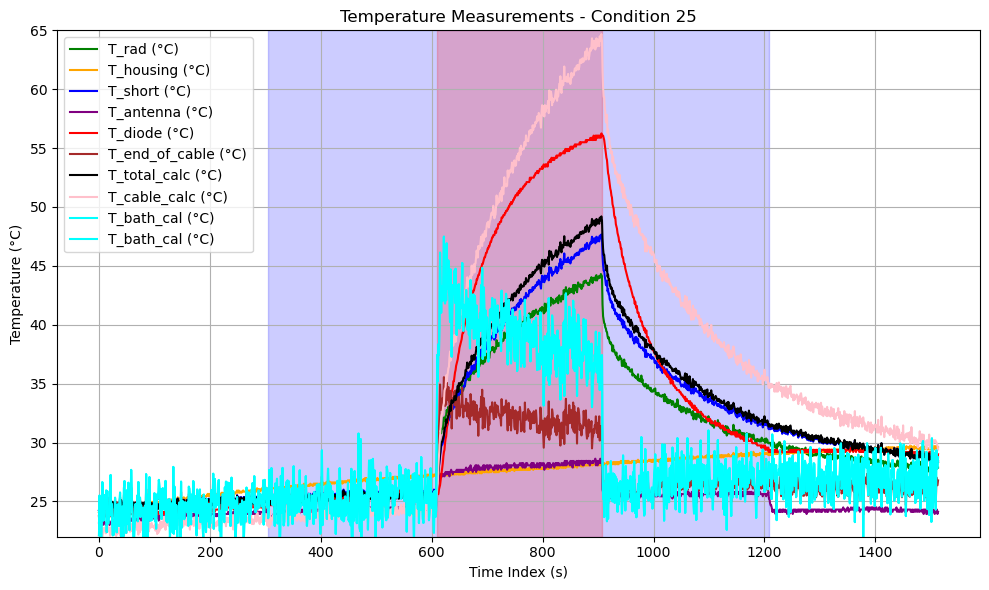

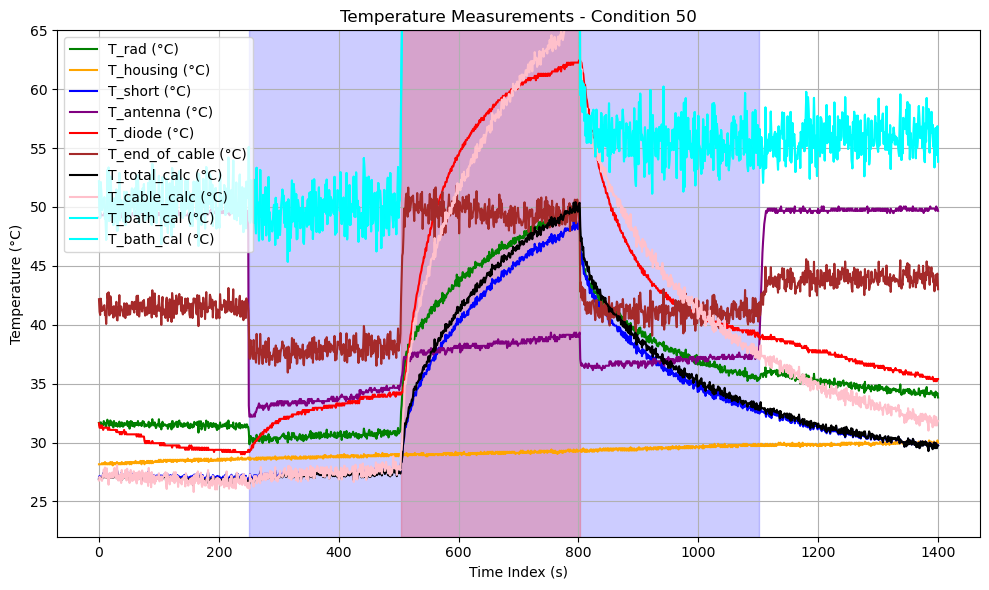

In [110]:
variables_left.append('T_bath_cal')
variables_colors['T_bath_cal'] = 'cyan'
labels['T_bath_cal'] = 'T_bath_cal (°C)'

y_axes_left_lims = (22, 65)

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Temperature Measurements - Condition {cond}"
        )

In [118]:
all_X["T_bath"] = all_X["condition"].astype(float)
all_X["T_handle_cal"] = all_X.apply(lambda row: calculate_T_handle(
    row["T_end_of_cable"],
    row["T_bath"],
    row["T_antenna"],
    tau_h,
    tau_a,
), axis=1)

In [119]:
all_X.iloc[490]

V_rad_short                                                  2063
V_rad_tot                                                    2007
V_housing                                                     805
V_diode                                                       178
V_spike                                                       181
cooling_flag_1                                                  1
cooling_flag_2                                                  0
power                                                         0.0
time_index                                                    490
file_idx                                                        0
file_name         Manual Calibration Full Setup Water Burn 50.txt
condition                                                      50
T_housing                                               29.021236
T_rad                                                   30.742071
T_short                                                 27.667388
T_antenna 

In [122]:
for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    print(cond_df[cond_df["power"] > 0].power.mean())

99.76588628762542
99.8428093645485


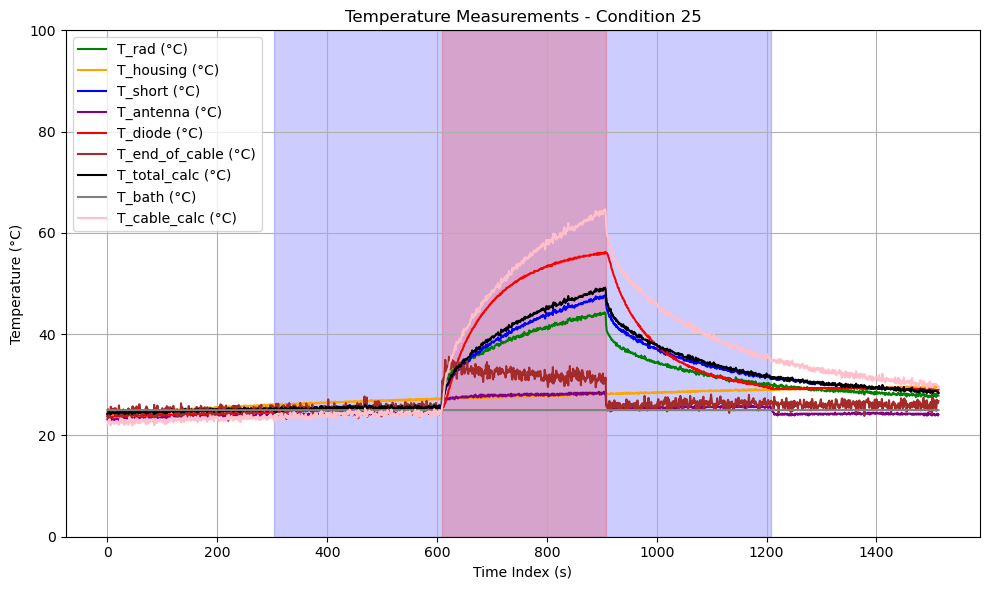

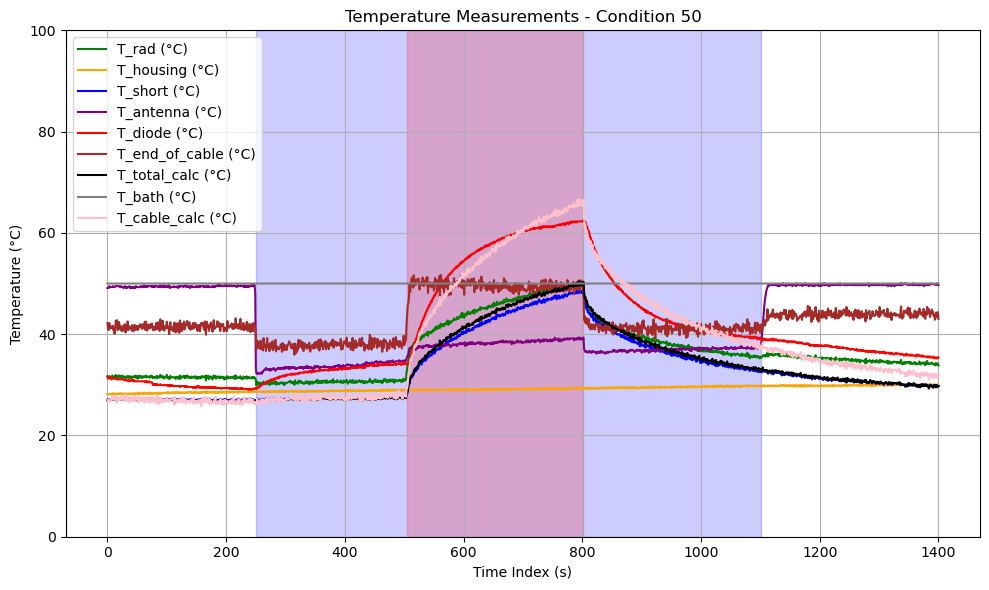

In [124]:
variables_left = ['T_rad', 'T_housing', 'T_short', 'T_antenna', 'T_diode', 'T_end_of_cable', 'T_total_calc']

variables_left.append('T_bath')
labels['T_bath'] = 'T_bath (°C)'
variables_colors['T_bath'] = 'grey'

variables_left.append('T_cable_calc')
labels['T_cable_calc'] = 'T_cable_calc (°C)'
variables_colors['T_cable_calc'] = 'pink'


# variables_left.append('T_handle_cal')
# variables_colors['T_handle_cal'] = 'magenta'
# labels['T_handle_cal'] = 'T_handle_cal (°C)'


y_axes_left_lims = (0, 100)

for cond in conditions:
    cond_df = all_X[all_X['condition'] == cond]
    plot(
        cond_df, variables_right, y_axes_right_lims,
        variables_left, y_axes_left_lims, variables_colors, labels, plot_title = f"Temperature Measurements - Condition {cond}"
        )


In [33]:
0.3*0.3


0.09